# import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import autoaugment, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
from tqdm import tqdm
import models.optimizer.optimizer as optimizer
from torch.optim.lr_scheduler import ReduceLROnPlateau
from helper.training_early_stop import EarlyStop
import helper.utility as utility
import os
from models.new_models import DCNN_v0 as m

# select device

In [ ]:
device = utility.select_devices(use_cudnn_if_avaliable=True)

using CUDA + cudnn


# Data Pre-processing

some dataset we use don't have validation set, split training dataset into training set and validation set by ratio

In [ ]:
utility.split_dataset_by_ratio(source_path='../dataset/train/', target_path='../dataset/split', ratio=0.8)

Target path [../dataset/split] is already existed.


### image transform
- use for transfom image dataset to tensor datatype
- data augmentation by rotation, flip, random crop, traslate, shear
- and also auto-augmentation for randomly apply different kinds of augmentations

In [ ]:
# Alex 227, VGG 224, ResNet 224, DCNN / custom 64
size = (64, 64)
batch_size = 32
channels = 1

# augmentation on rotation, vertical/horizontal filp, random crop, translate, shear
data_transforms_R = utility.grayscale_transform_rotation(channels, size, 25,)
data_transforms_vf = utility.grayscale_transform_verticalflip(channels, size, 0.8)
data_transforms_hf = utility.grayscale_transform_horizontalflip(channels, size, 0.8)
data_transforms_crop = utility.grayscale_transform_crop(channels, size, scale=(0.2, 1))
data_transforms_translate = utility.grayscale_transform_trainslate(channels, size, value=(0.2, 0))
data_transforms_shear = utility.grayscale_transform_shear(channels, size, value=(-10, 10))

# resize image and transform to single channel without any kind of augmentation
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=channels), 
    transforms.Resize(size),
    transforms.ToTensor()
])

# Auto-Augment with different kinds of transfrom
transforms_AutoAug = transforms.Compose([
    transforms.Grayscale(num_output_channels=channels), 
    transforms.RandomResizedCrop(size),
    transforms.RandomHorizontalFlip(0.5),
    autoaugment.AutoAugment(),
    transforms.ToTensor()
])


### data duplicated (use if needed)

In [ ]:
class_list = ['disgust', 'fear']
utility.create_augmentation_dataset('../RAF-DB/splited_data/train_data/', 'RAFDB12', class_list)

data augmentation is already created at [../augmentation_dataset/RAFDB12]


### add noise
- gaussian(mean=0, sigma=25) noise
- salt(p=0.2)-pepper(p=0.2) noise


In [ ]:
# path of original image dataset
input_folder = "../RAF-DB/splited_data/train_data/"
# output path of noisy dataset
output_folder = "../RAF-DB/splited_data/mix_noisy_train_data"
# apply noise to what classes
noisy_classes = ['angry', 'happy', 'netural', 'sad', 'suprise'] 

# function to add noise to image, will not override if the output path is existed.
# type: 0-gaussian, 1-pepper+salt, 3-mix with gaussian and pepper-salt
# prob: the probability to apply noise to an image
utility.add_noise(input_folder, output_folder, noisy_classes, prob=0.5, type=2)

folder [../RAF-DB/splited_data/mix_noisy_train_data] is already existed


### create dataloader

#### dataloader
To create dataloader after image transfomation
- the dataset itself to dataloader
- combined dataset to a single dataloader


In [ ]:
# original dataset path
train_path = '../RAF-DB/splited_data/train_data'
train_path2 = '../dataset/split/train_data/'
train_path3 = '../dataset2_MMAFEDB/train/'

# duplicated dataset path create using utility.create_augmentation_dataset()
aug_train_path = train_path2#'../augmentation_dataset/RAFDB12/'
aug_train_path2 = '../augmentation_dataset/FER2013/'

# validation set and tet set path
val_path = '../RAF-DB/splited_data/validation_data/'
val_path2 = '../dataset/split/validation_data/'

test_path = '../RAF-DB/test'
test_path2 = '../dataset/test/'

# transform and apply augmentation on duplicated dataset
rotation = datasets.ImageFolder(aug_train_path, transform=data_transforms_R)
vertical_flip = datasets.ImageFolder(aug_train_path, transform=data_transforms_vf)
horizontal_flip = datasets.ImageFolder(aug_train_path, transform=data_transforms_hf)
crop = datasets.ImageFolder(aug_train_path, transform=data_transforms_crop)
shear = datasets.ImageFolder(aug_train_path, transform=data_transforms_shear)
translate = datasets.ImageFolder(aug_train_path, transform=data_transforms_translate)

# apply transform to original dataset
train_dataset1 = datasets.ImageFolder(train_path, transform=data_transforms)
train_dataset2 = datasets.ImageFolder(train_path2, transform=data_transforms)
train_dataset3 = datasets.ImageFolder(train_path3, transform=data_transforms)

# combine transformed dataset
# train_dataset1 = ConcatDataset([train_dataset1, train_dataset2, train_dataset3])
# train_dataset1 = ConcatDataset([train_dataset1, crop, shear, translate, rotation, horizontal_flip])
train_dataset2 = ConcatDataset([train_dataset2, crop, shear, translate, rotation, horizontal_flip])

# combine transformed dataset with auto-augmentation
# dataset_list = [train_dataset1, train_dataset2]
# for _ in range(2): # do auto-augmentation by how many times
#     dataset_list.append(datasets.ImageFolder(aug_train_path, transform=transforms_AutoAug))
#     dataset_list.append(datasets.ImageFolder(aug_train_path2, transform=transforms_AutoAug))
# train_dataset1 = ConcatDataset(dataset_list)

# transform val and test set
val_dataset1 = datasets.ImageFolder(val_path, transform=data_transforms)
val_dataset2 = datasets.ImageFolder(val_path2, transform=data_transforms)

test_dataset1 = datasets.ImageFolder(test_path, transform=data_transforms)
test_dataset2 = datasets.ImageFolder(test_path2, transform=data_transforms)

# create dataloader
train_loader = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=16)
val_loader = DataLoader(val_dataset2, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=16)
test_loader = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False, pin_memory=False, num_workers=16)

#### select data loader

In [ ]:
tl = train_loader
vl = val_loader
test_l1 = test_loader
test_l2 = test_loader
test_l3 = test_loader

### check data detial
output the number of samples in dataloader

In [ ]:
print('Train label:')
train_label_count = utility.check_label_size(tl)
print('val label:')
val_label_count = utility.check_label_size(vl)

Train label:


Label 0: 19176 samples
Label 1: 2088 samples
Label 2: 19662 samples
Label 3: 34632 samples
Label 4: 23832 samples
Label 5: 23184 samples
Label 6: 15216 samples
val label:
Label 0: 799 samples
Label 1: 88 samples
Label 2: 820 samples
Label 3: 1443 samples
Label 4: 993 samples
Label 5: 966 samples
Label 6: 635 samples


# Model parameter

In [ ]:
optimizer_name = "Adam"  # or "SGD"

# name of the folder to store this experiment
dataset = '_[FER(aug)]' # the data use for this experiment

lr = '' # if use lr scheduler, otherwise empty string, eg:_LR

# if use weight balance in loss function
# A: adjust weight base on accuracy, M: manual assign weight, D: adjust weight bsase on data distribution
# eg: _WB(A)
wb = ''
L2 = 0.0 # weight decay rate, L2 regulization
smooth = 0 # value of label smoothing

# add to the end of the name of folder if use L2 regulization or label smooth
additional =''
# additional = f'_[L2:{L2}]'
# additional = f'_[L2:{L2},smooth:{smooth}]'

# update saving path with above imofrmation
m.update_file_name(optimizer_name + dataset + lr + wb + additional)

# create direcroy if not exist
if not os.path.exists(m.record_save_path):
    os.makedirs(m.record_save_path)

# initialize model
model = m.EmotionCNN(num_classes=7, input_channel=channels)

In [ ]:
# adjust the weight of each label. 1: data distribution 2: base on accuracy 3: manual assign
list1 = train_label_count.values()
list2 = [0.71, 0.41, 0.55, 0.93, 0.84, 0.82, 0.79]
list3 = [1.5, 2.25, 2.25, 0.3, 0.8, 0.8, 0.7]

print(f'Distribution: {list1}\nvanilla accuracy: {list2}')

# Calculate weights base on the input list
def adjust_weights(list1, list2, list3, wb):
    if wb == '':
        return None
    if '(D)' in wb:
        print('use distribution weight')
        list = list1
    elif '(M)' in wb:
        print('use manual assign weight')
        print(list3)
        return torch.tensor(list3)
    else:
        print('use vanilla accuracy weight')
        list = list2
    weights = [1.0 / e for e in list]
    weights_sum = sum(weights)
    weights = [w / weights_sum for w in weights]
    weights_tensor = torch.tensor(weights)
    print(list)
    print(weights_tensor)
    return weights_tensor
weights_tensor = adjust_weights(list1, list2, list3, wb)

# apply weight to loss function
criterion = nn.CrossEntropyLoss(weight=weights_tensor).to(device) 

Distribution: dict_values([19176, 2088, 19662, 34632, 23832, 23184, 15216])
vanilla accuracy: [0.71, 0.41, 0.55, 0.93, 0.84, 0.82, 0.79]


In [ ]:
# optimizer
optimizer_ = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=L2) # defalut lr-0.0001, L2: 0.001

# lr scheduler
lr_scheduler = ReduceLROnPlateau(
            optimizer_,
            mode='max',                 # 'max' for monitoring validation accuracy
            factor=0.4,                 # factor by which the learning rate will be reduced
            patience=2,                 # number of epochs with no improvement to trigger LR reduction
            min_lr=1e-7,                # minimum learning rate
            verbose=1                   # (1: print messages, 0: not print message)
        )

In [ ]:
# average loss / epoch
loss_history_per_epoch = []
# correct prediction / epoch
correct_prediction_pre_epoch = []
# accuracy / epoch
accuracy_per_epoch = []
# validation loss
val_loss_per_epoch = []
# validation accuracy
val_accuracy_per_epoch = []

#### earlystoping parameters

In [ ]:
# training model
num_epochs = 200

# early stopping variables
stop_counter = 10 # number of count to trigger early stop
stop_counter_window = 15 # a range to check stop_counter
loss_different = 0.001 # different between the best val loss and the most recent one
accuracy_different = 0.0025
stop_counter_interval = 30 # check for early stop for every stop_counter_interval
counter = 0 # number of count for every trail of early stop
is_always = True # always check for early stop, set to true will ignore other setting except stop_counter
is_exe = False # is early stop running
run_after =0
early_stopping = EarlyStop(m.pth_save_path, m.pth_save_path_loss, stop_counter, 
                           accuracy_different, loss_different, type="accuracy")

# 2. Model training

In [ ]:
model.to(device)
stop = True
# progress bar
process = tqdm(range(num_epochs), bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}', colour='green', unit='epoch')

for epoch in process:
    running_loss = 0.0
    accuracy = 0.0
    model.train()
    for inputs, labels in tl:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        optimizer_.zero_grad()
        probability = nn.functional.softmax(outputs, dim=1)
        prediction = torch.argmax(probability, dim=1)
        num_correct_prediction = (prediction == labels).sum().item()
        correct_prediction_pre_epoch.append(num_correct_prediction)
        accuracy += num_correct_prediction / inputs.shape[0]
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer_.step()
    # save training status
    loss_history_per_epoch.append((running_loss / len(tl)))
    accuracy_per_epoch.append((accuracy / len(tl)))

    # training validation + early stopping
    if epoch >= run_after and (is_always or is_exe or epoch % stop_counter_interval == 0):
        val_loss = 0.0
        val_accuracy = 0.0

        if not is_always and epoch% stop_counter_interval ==0:
            early_stopping.counter = 0
            is_exe = True

        counter += 1

        if not is_always and counter >= stop_counter_window:
            counter = 0
            is_exe = False
        model.eval()
        with torch.no_grad():
            for inputs, labels in vl:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                probability = nn.functional.softmax(outputs, dim=1)
                prediction = torch.argmax(probability, dim=1)
                num_correct_prediction = (prediction == labels).sum().item()
                accuracy = num_correct_prediction / inputs.shape[0]
                val_accuracy += accuracy
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss = val_loss / len(vl)
        val_accuracy = val_accuracy / len(vl)
        val_loss_per_epoch.append(val_loss)
        val_accuracy_per_epoch.append(val_accuracy)

        early_stopping.check_status(model, val_accuracy, val_loss)

        # display recently 5 average loss of epochs
        process.set_description(f"loss= {'{:.5f}'.format(loss_history_per_epoch[-1])} - "
                                f"val loss= {'{:.5f}'.format(val_loss_per_epoch[-1])} - "
                                f"best_loss= {'{:.5f}'.format(early_stopping.best_of_all_value_loss)} - "
                                f"accuracy= {'{:.3%}'.format(accuracy_per_epoch[-1])} - "
                                f"val accuracy= {'{:.3%}'.format(val_accuracy_per_epoch[-1])} - "
                                f"best= {'{:.3%}'.format(early_stopping.best_of_all_value)} - "
                                f"Counter= {early_stopping.counter}/{stop_counter}")
        if lr != '':
            lr_scheduler.step(val_accuracy)
    else:
        process.set_description(f"loss= {'{:.5f}'.format(loss_history_per_epoch[-1])} - "
                                f"accuracy= {'{:.3%}'.format(accuracy_per_epoch[-1])}")

    if stop and early_stopping.early_stop:
        print('\nTrigger Early Stopping\n')
        early_stopping.early_stop = False
        break

  0%|                    | 0/200 [00:00<?, ?epoch/s]

# 3. Save model and records
- save the model parameter as .pth file
- save the training / val accuracy, training / val loss as pickle file, will be use for plot

In [ ]:
torch.save(model.state_dict(), m.pth_manual_save_path)

utility.save_pickle_files(loss_history_per_epoch, m.record_save_path + '/loss_history.pkl')
utility.save_pickle_files(accuracy_per_epoch, m.record_save_path + '/accuracy_history.pkl')
utility.save_pickle_files(val_loss_per_epoch, m.record_save_path + '/val_loss_history.pkl')
utility.save_pickle_files(val_accuracy_per_epoch, m.record_save_path + '/val_accuracy_history.pkl')

# 4. Plot records and Evaluation

### Plots

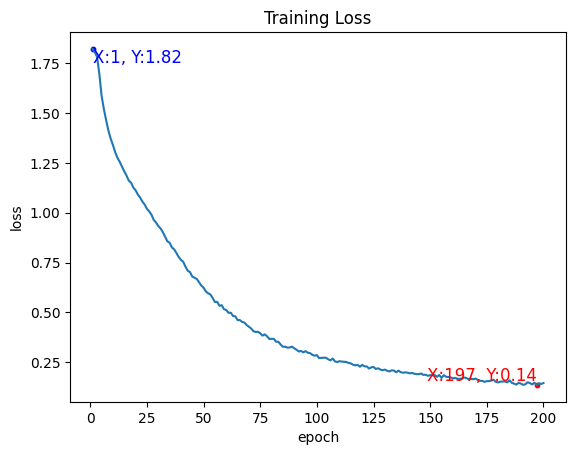

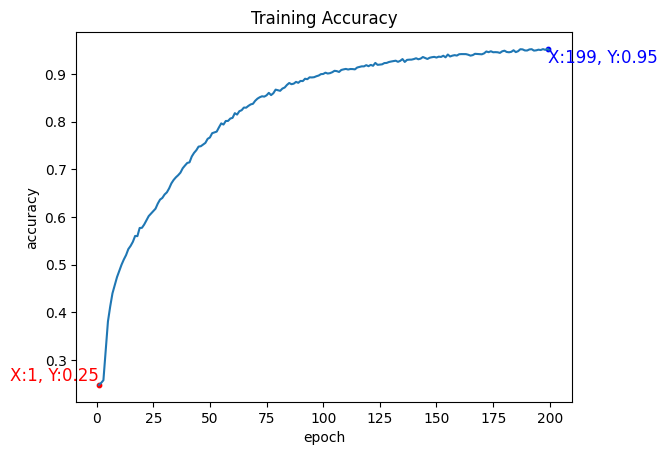

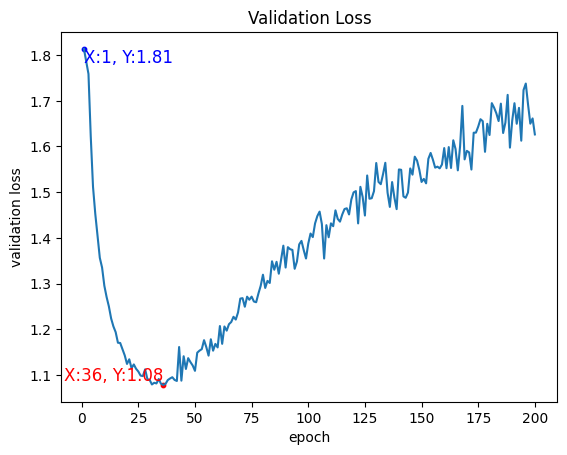

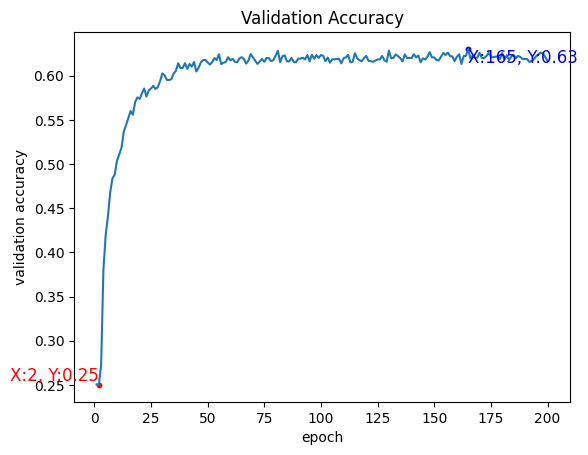

In [ ]:
# draw graphs
data = utility.read_pickle_files(m.record_save_path + '/loss_history.pkl')
utility.plot_record(x=range(1, len(data)+1), y=data, xlabel="epoch", ylabel="loss", title="Training Loss", 
                    save_path=m.record_save_path+"/loss_history.png")

data = utility.read_pickle_files(m.record_save_path + '/accuracy_history.pkl')
utility.plot_record(x=range(1, len(data)+1), y=data, xlabel="epoch", ylabel="accuracy", title="Training Accuracy",
                    save_path=m.record_save_path+"/accuracy_history.png")

data = utility.read_pickle_files(m.record_save_path + '/val_loss_history.pkl')
utility.plot_record(x=range(run_after+1, run_after+len(data)+1), y=data, xlabel="epoch", ylabel="validation loss",
                    title="Validation Loss", save_path=m.record_save_path+"/val_loss_history.png")

data = utility.read_pickle_files(
    m.record_save_path + '/val_accuracy_history.pkl')
utility.plot_record(x=range(run_after+1, run_after+len(data)+1), y=data, xlabel="epoch", ylabel="validation accuracy",
                    title="Validation Accuracy", save_path=m.record_save_path+"/val_accuracy_history.png")


### Test Accuracy
Evaluate the model with 3 sets of parameter. During the training, we save the model parameter if it reachs a high a ccuracy, a lower loss, and the model parameter after early stop. Total of 3 sets of parameter

model weight path: ./model_data/DCNN/v0_Adam_[FER2013]/model.pth


Test Accuracy: 61.47952075787127%
              precision    recall  f1-score   support

           0       0.51      0.56      0.53       958
           1       0.68      0.51      0.58       111
           2       0.48      0.37      0.42      1024
           3       0.80      0.84      0.82      1774
           4       0.55      0.57      0.56      1233
           5       0.49      0.49      0.49      1247
           6       0.76      0.76      0.76       831

    accuracy                           0.61      7178
   macro avg       0.61      0.59      0.59      7178
weighted avg       0.61      0.61      0.61      7178

model weight path: ./model_data/DCNN/v0_Adam_[FER2013]/manual_save_model.pth
Test Accuracy: 60.61577040958484%
              precision    recall  f1-score   support

           0       0.53      0.54      0.53       958
           1       0.73      0.50      0.60       111
           2       0.46      0.42      0.44      1024
           3       0.81      0.81      0.

0.5916689885762051

<Figure size 700x700 with 0 Axes>

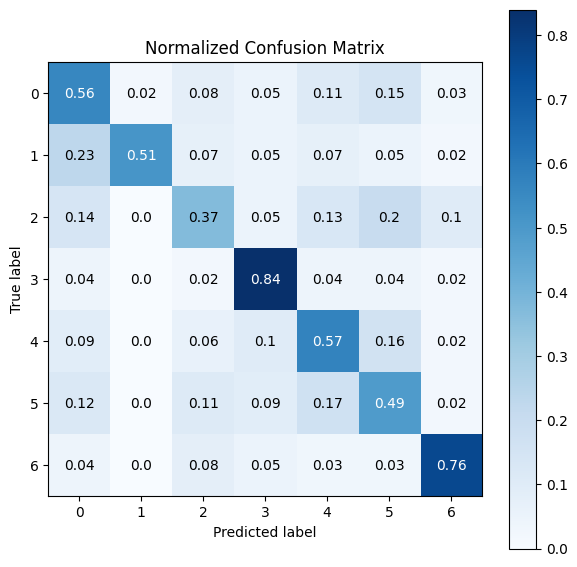

<Figure size 700x700 with 0 Axes>

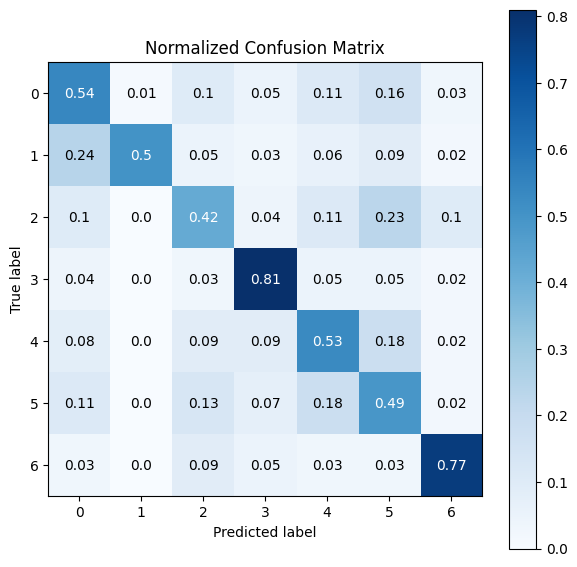

<Figure size 700x700 with 0 Axes>

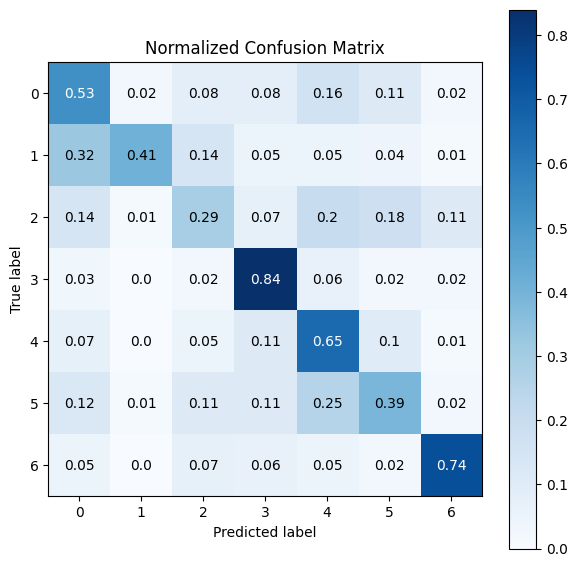

In [ ]:
# evaluate model
print(f'model weight path: {m.pth_save_path}')
utility.model_validation(model, device, test_l1, m.pth_save_path, m.record_save_path, file_name='1')
print(f'model weight path: {m.pth_manual_save_path}')
utility.model_validation(model, device, test_l2, m.pth_manual_save_path, m.record_save_path, file_name='2')
print(f'model weight path: {m.pth_save_path_loss}')
utility.model_validation(model, device, test_l3, m.pth_save_path_loss, m.record_save_path, file_name='3')